# Imports

In [0]:
import pandas as pd
import numpy as np
from scipy import sparse
from google_drive_downloader import GoogleDriveDownloader as gdd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import os
import lightgbm as lgb
import itertools
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})

In [0]:
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download('punkt')
 
cachedStopWords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
def word_importance(var_imp):
    plt.figure(figsize=(15,10))

    d = {}
    for k,v in var_imp.to_dict()['importance'].items():
        d[k] = float(v)


    wordcloud = WordCloud(width=2000,height=1200, max_words=200, relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Reading data

In [0]:
gdd.download_file_from_google_drive(file_id='1Okw_xIM2KzFKAIy0nh7iKrysbBxud28j',\
                                    dest_path='/data/LargeMovieReviewDataset.csv')
data = pd.read_csv('/data/LargeMovieReviewDataset.csv')

In [0]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Данные представляют из себя кинорецензии с метками.

In [0]:
data.shape

(50000, 2)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [0]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

# Preprocessing

Закодируем метки, где 0 - негативный отзыв, а 1 - положительный.

In [0]:
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Посмотрим на среднее количество слов в рецензии:



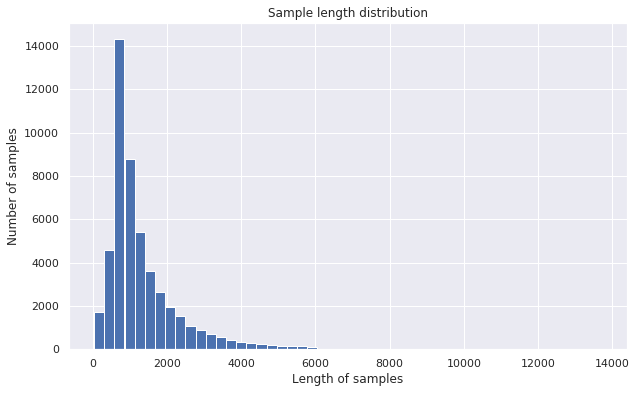

In [0]:
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(data['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

## Removing unnecessary characters and noise text

Уберем лишние шумы из данных, такие как: различные скобки, различные символы, отличные от алфавитных и т.д.

In [0]:
from bs4 import BeautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
  
data['review'] = data['review'].apply(denoise_text)

In [0]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
data['review'] = data['review'].apply(remove_special_characters)

## Lemmatization

In [0]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
%%time

from nltk.stem import WordNetLemmatizer
def simple_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    text= ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text
  
data['review'] = data['review'].apply(simple_lemmatizer)

CPU times: user 59.2 s, sys: 256 ms, total: 59.4 s
Wall time: 59.4 s


## Removing stopwords

In [0]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [0]:
stop=set(stopwords.words('english'))
print(stop)

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

  
data['review'] = data['review'].apply(remove_stopwords)

{'at', 'yours', 'doing', 'through', 'aren', 'ourselves', "didn't", 'other', 'just', 'below', 'off', 'were', 'how', 'each', 'the', 'from', 'her', 'are', 'only', 're', 'until', 'himself', 'don', 'where', 'for', 'we', 'can', 'i', 'what', 'me', 'on', "hasn't", 'he', 'then', "haven't", 'ma', 'do', 'been', 'be', 'few', 'and', "shan't", 'd', 'any', "you'll", 'again', 'it', 'hasn', 'yourself', 'my', 'has', 'into', 'isn', 'you', 'll', 'most', 'wasn', 'mustn', 'between', 'your', "you'd", 'when', 'this', 'had', 'more', 'm', 'mightn', 's', 'doesn', 'about', 'than', 'under', 'which', 'those', 'weren', 'have', 'him', 'our', 'am', 'here', 'theirs', 'o', 'whom', 'was', 'but', "won't", 'by', 't', 'couldn', 'against', 'his', 'ain', 'if', "mightn't", 'same', 'down', 'didn', 'once', "should've", 'that', 'such', 'is', "needn't", 'why', "hadn't", 'so', 'won', 'an', 'ours', 'myself', 'hadn', 'of', 'nor', 'very', 'its', "don't", 'with', 'shouldn', 'further', "aren't", 'itself', 'who', "couldn't", 'after', 'th

## Text feature extraction

### CountVectorizer

Теперь используем CountVectorizer для векторизации предложений. Он берет слова каждого предложения и создает словарь всех уникальных слов в предложениях. Этот словарь можно затем использовать для создания векторного признака количества слов:



In [0]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

vect_texts = vectorizer.fit_transform(list(data['review']))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

CPU times: user 7.56 s, sys: 206 ms, total: 7.77 s
Wall time: 7.78 s


Построим график распределения частот наиболее часто встречающихся слов из оставшихся в корпусе:

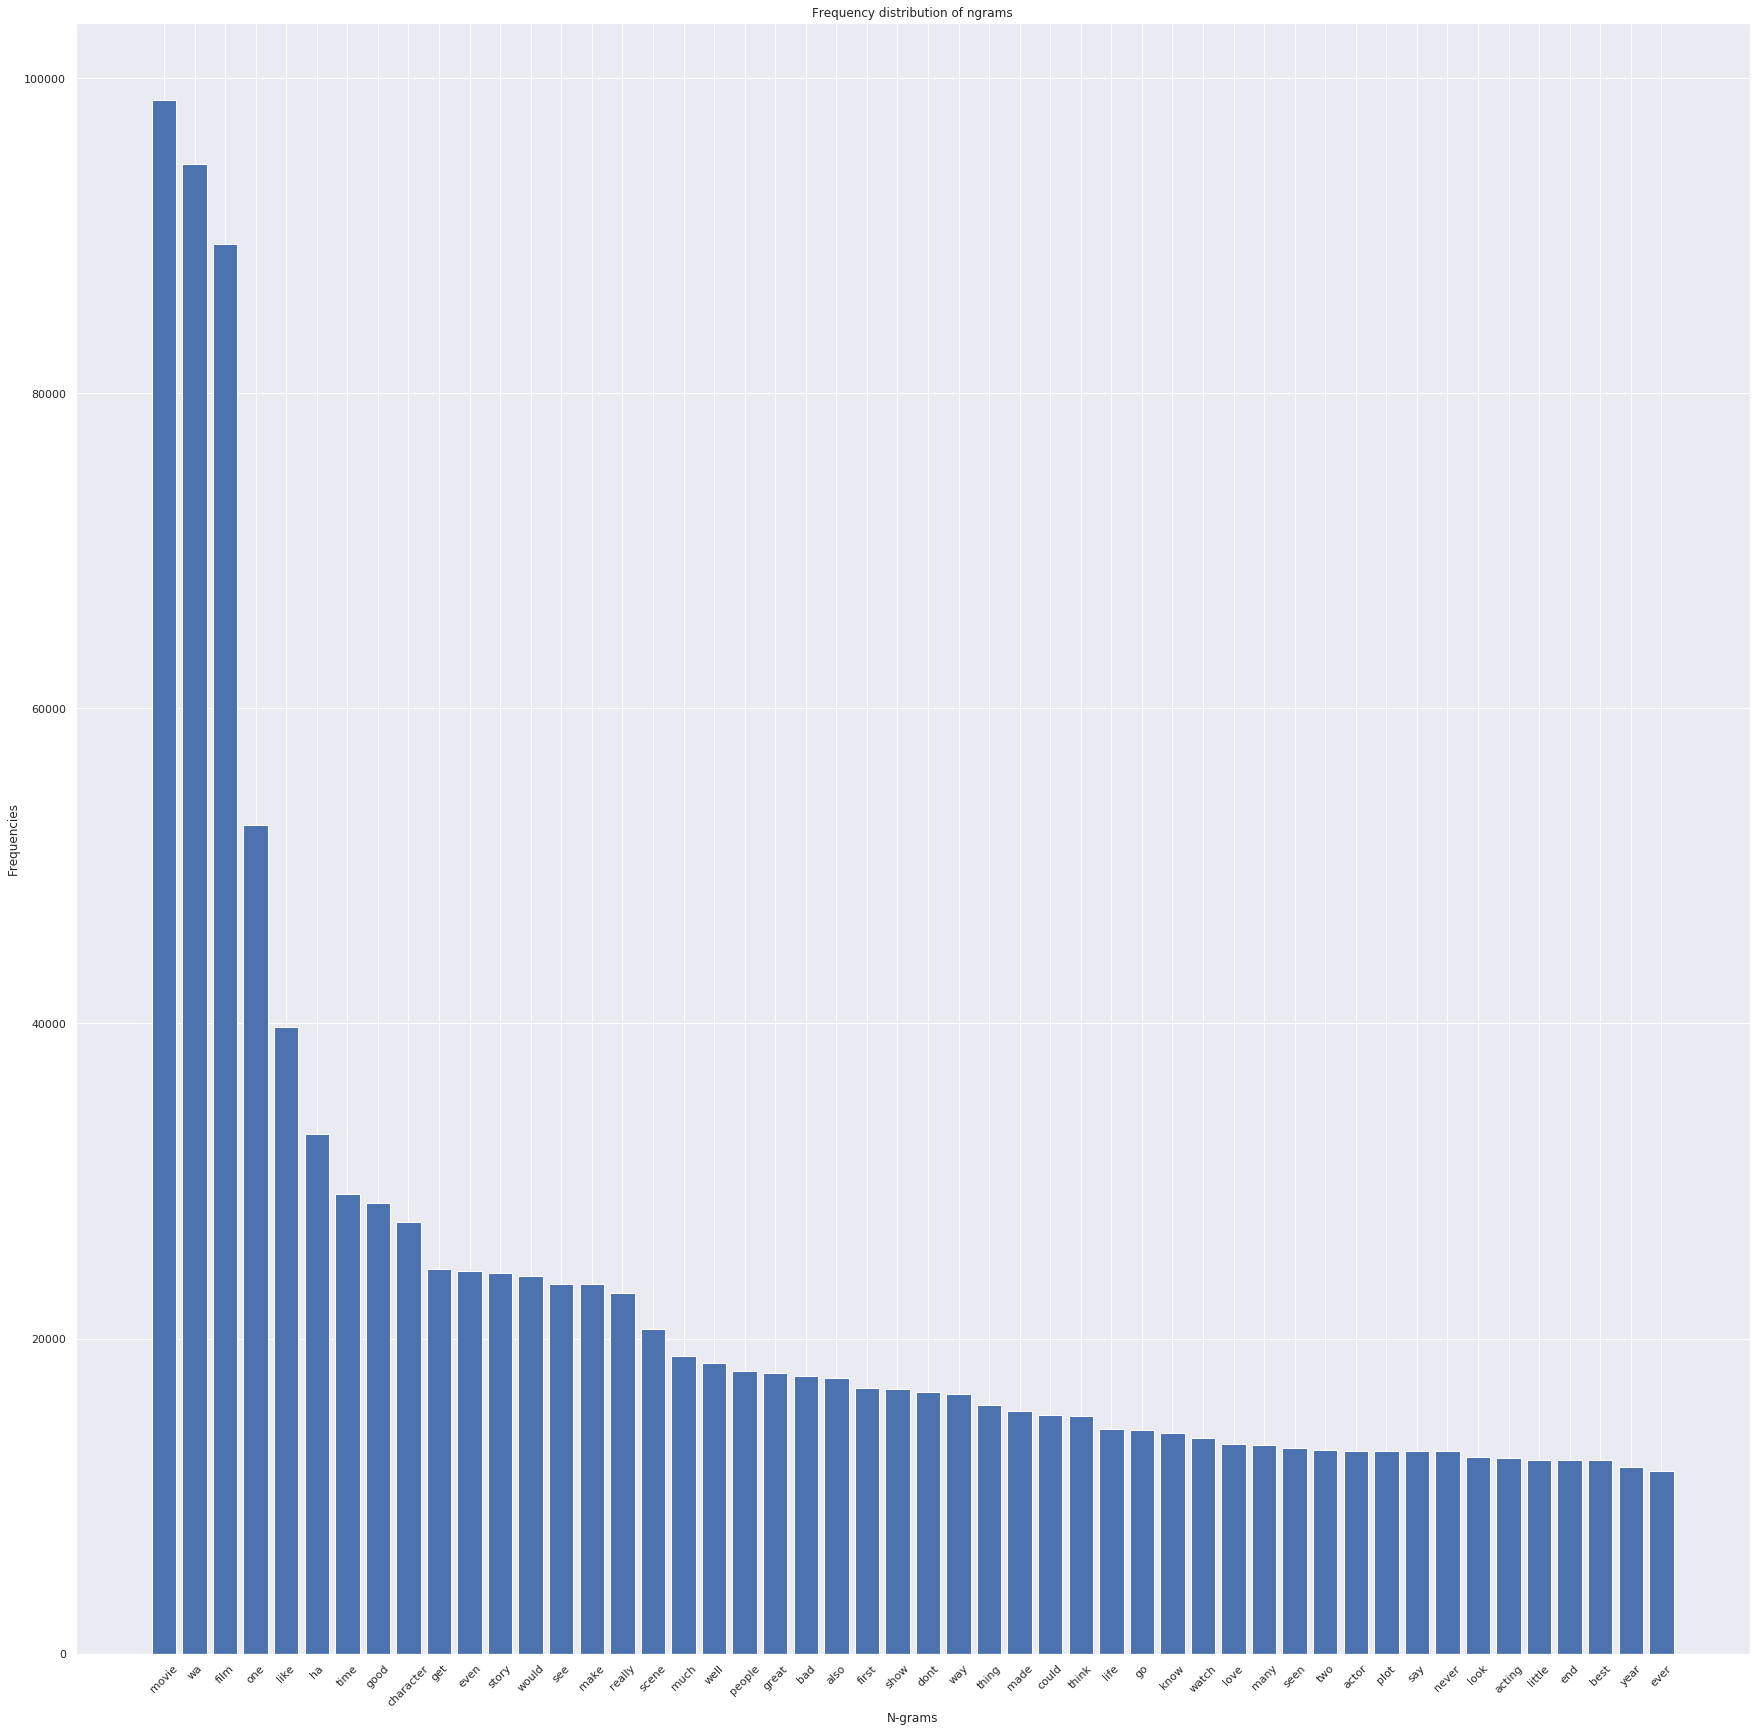

In [0]:
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

### TF-IDF

С помощью TF-IDF мы хотим уменьшить важность токенов, которые очень часто встречаются в нашем корпусе, так как они, предположительно, менее информативны, чем некоторые фичи, которые встречаются реже. Например, "movie" и "film" несмотря на свою частоту, вероятно, несут мало смысла.

In [0]:
%%time

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : (1, 2),
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : 'word',
        'min_df' : 2,
    }
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    feature_names = np.array(tfidf_vectorizer.get_feature_names())

    # Выберем 20000 лучших фич 
    selector = SelectKBest(f_classif, k=min(20000, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32') 
    feature_names = feature_names[selector.get_support()]
    
    return transformed_texts, feature_names
  
  
# Векторизируем дату и вернем имена фич для word importance
vect_data, feature_names = ngram_vectorize(data['review'], data['sentiment'])

CPU times: user 49.7 s, sys: 1.32 s, total: 51 s
Wall time: 50.9 s


Мы выбрали 20к фичей, можно и больше, но не хватает памяти.

## Train-test split

In [0]:
X = vect_data.toarray()
y = (np.array(data['sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


# Models

## SGD

In [0]:
%%time
sgd = SGDClassifier(loss='hinge',random_state=42)
sgd_clf = sgd.fit(X_train,y_train)
sgd_predict=sgd.predict(X_test)
print(sgd_predict)


[0 1 0 ... 1 0 1]
CPU times: user 44.8 s, sys: 5.15 s, total: 49.9 s
Wall time: 49.2 s


In [0]:
sgd_score = roc_auc_score(y_test,sgd_predict)
print("sgd score :",sgd_score)

sgd score : 0.8877741521794185


## BernoulliNB

In [0]:
%%time
bnb = BernoulliNB()
bnb_clf = bnb.fit(X_train,y_train)
bnb_predict = bnb.predict(X_test)
print(bnb_predict)

[1 1 0 ... 1 0 0]
CPU times: user 12 s, sys: 5.9 s, total: 17.9 s
Wall time: 14.5 s


In [0]:
bnb_score = roc_auc_score(y_test,bnb_predict)
print("bnb score :",bnb_score)

bnb score : 0.9028755309473028


## GaussianNB

In [0]:
%%time
gnb = GaussianNB()
gnb_clf = gnb.fit(X_train,y_train)
gnb_predict = gnb.predict(X_test)
print(gnb_predict)

[0 1 0 ... 1 0 1]
CPU times: user 11.7 s, sys: 225 ms, total: 11.9 s
Wall time: 11.8 s


In [0]:
gnb_score = roc_auc_score(y_test, gnb_predict)
print("gnb score :", gnb_score)

gnb score : 0.9099767429850432


Пока что наш победитель!

## SVM

 Падает по RAM на colab'е, странно.

In [0]:
%%time
'''
svm_clf = svm.SVC()
svm_model = svm_clf.fit(X_train,y_train)
svm_predict = svm_model.predict(X_test)
print(svm_predict)
'''


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


'\nsvm_clf = svm.SVC()\nsvm_model = svm_clf.fit(X_train,y_train)\nsvm_predict = svm_model.predict(X_test)\nprint(svm_predict)\n'

In [0]:
'''
svm_score = roc_auc_score(y_test, svm_predict)
print("svm score :", svm_score)
'''

'\nsvm_score = roc_auc_score(y_test, svm_predict)\nprint("svm score :", svm_score)\n'

## LightGBM

In [0]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier()
lgb_model = lgb_clf.fit(X_train,y_train)    
lgb_pred = lgb_model.predict(X_test)

In [0]:
lgb_score = roc_auc_score(y_test, lgb_pred)
print("lgb score :", lgb_score)

lgb score : 0.8655122577657626


LGB не показал тех результатов, которые от него обычно ожидают:)

## Hyperparameters tuning

In [0]:
from hyperopt.fmin import fmin
from hyperopt import hp, tpe
from sklearn.model_selection import cross_val_score
hp_space ={     'num_leaves' : 31,
                'max_depth': -1,
                'min_child_samples': 1 + hp.randint('min_child_samples', 40),
                'subsample_for_bin': 200000,
                'n_estimators': 100,
                'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.0001),
                'lambda_l1' : 0,
                'lambda_l2' : 0,
                'learning_rate' : hp.quniform('learning_rate', 0.001, 0.1, 0.001),
                'boosting_type' : 'gbdt',
                'subsample_freq' : 0 ,
                'colsample_bytree' : 1,
                'min_child_weight' : 0.001
            }
def hyperopt_lgb_score(params):
    lgbr = lgb.LGBMClassifier(**params)
    current_score = cross_val_score(lgbr, X_train, y_train, scoring='roc_auc', cv=2).mean()
    print(-current_score, params)
    return -current_score

In [0]:
lgb_clf

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Долго работает, поэтому закомментировал. Нужно запустить на пять часов, чтобы найти хорошее решение:

In [0]:
# best = fmin(fn=hyperopt_lgb_score, space=hp_space, algo=tpe.suggest, max_evals=500,verbose=-1)

In [0]:
best = {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.099, 
        'max_depth': -1, 'min_child_samples': 31, 'min_child_weight': 0.001, 'min_split_gain': 0.0106, 'n_estimators': 100,
        'num_leaves': 31, 'subsample_for_bin': 200000, 'subsample_freq': 0}



In [0]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(**best)
lgb_model = lgb_clf.fit(X_train,y_train)    
lgb_pred = lgb_model.predict(X_test)

In [0]:
lgb_score = roc_auc_score(y_test, lgb_pred)
print("lgb score :", lgb_score)

lgb score : 0.8635770400271152


Похоже, что LGB не очень подходит для решения такого рода задач. Вероятно, из-за высокого количества признаков. Насколько мне известно, нейросети могут намного лучше.

# Words importance

In [0]:
var_imp = pd.DataFrame(index=feature_names)
var_imp['importance'] = sgd_clf.coef_[0]
var_imp_pos = var_imp.sort_values('importance', ascending=False)

In [0]:
var_imp_pos

,importance
great,5.789432
excellent,4.896374
best,3.768754
wonderful,3.336421
perfect,3.331488
well,3.289936
favorite,3.180231
fun,3.179494
amazing,3.117429
love,3.067289


In [0]:
var_imp_neg = var_imp_pos.copy()
var_imp_neg['importance'] = -1*var_imp_neg['importance']

##Positive words

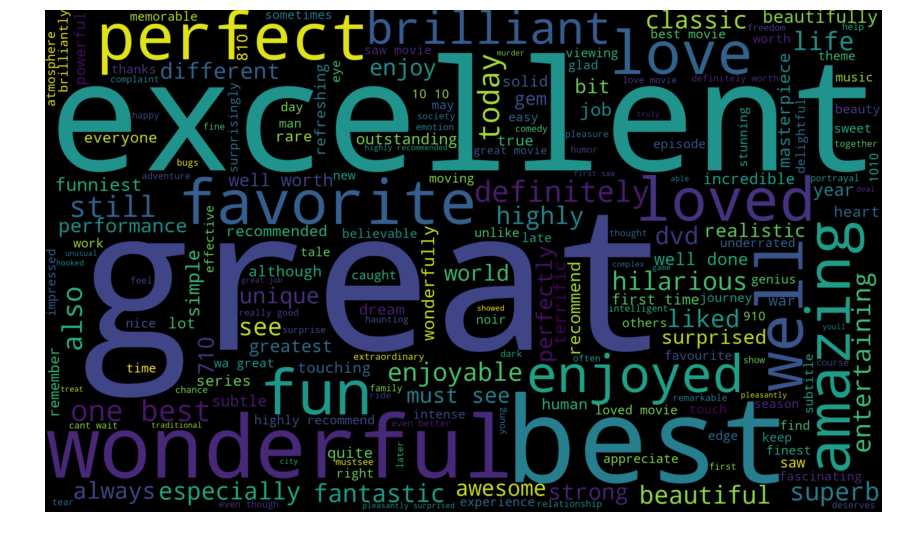

In [0]:
word_importance(var_imp_pos)

## Negative words

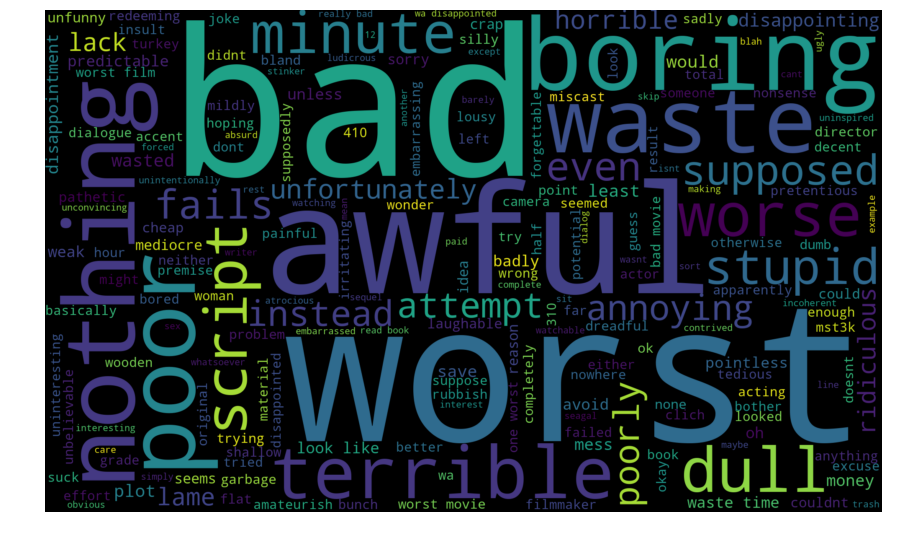

In [0]:
word_importance(var_imp_neg)